## Introduction

### Recently I started with NLP and after going through several articles and algorithms I thought to implement it. So in this kernel I am try to implement them. Data is of Stack OverFlow and I'll try to understand what the key words are in the coupus. 

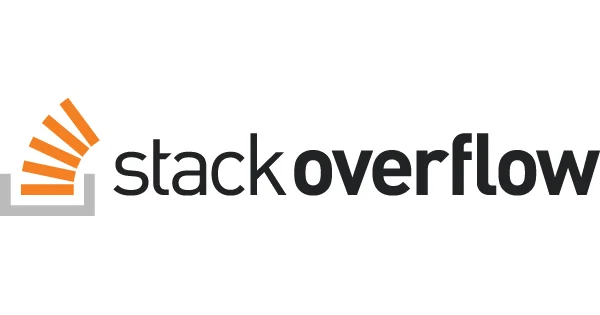

## Table -- 
1. [ Getting Started](#The_Data) 
    * [Import Liberay](#Lib)
    * [Explore Data](#Display)
2. [Pre-Processing](#Pre-Processing) 
    * [Cleaning Text](#Cleaning)
    * [Bigrams](#Bigrams)
    * [Most Frequent Words](#Frequent)
3. [Training the model](#Model)
    * [The parameters](#parms)
    * [Building the Vocabulary Table](#Vocab)
    * [Training of the model](#Training)
4. [Exploring the model](#Exploring)
    * [Most similar to](#similar)
    * [t-SNE visualizations](#t-SNE)
5. [PLOTS](#PLOTS)
6. [Conclusion](#Conclusion)

## <a id="The_Data">The Data : </a>

Its a collection of 60,000 Stack Overflow questions from 2016-2020 and classified them into three categories:

HQ: High-quality posts with 30+ score and without a single edit.
LQ_EDIT: Low-quality posts with a negative score and with multiple community edits. However, they still remain open after the edits.
LQ_CLOSE: Low-quality posts that were closed by the community without a single edit.


## <a id="Lib">Import Liberay </a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import random
import warnings

from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve

warnings.simplefilter("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
data = pd.read_csv("/kaggle/input/60k-stack-overflow-questions-with-quality-rate/data.csv")

## <a id="Display"> Let's look at the Data</a>

In [ ]:
display(data.info(),data.head())

## <a id='Pre-Processing'>Pre-Processing</a> 

Note:- We are currently going to use only two columns but we are still going to keep 2 more columns just for later use
<ul>
  <li>1. <code> Id , CreationDate </code> were not usefull at the current point. </li>
  <li>2. And let's transform the <code> 'Y' </code> column into " 0,1,2 " </li>
</ul>

In [ ]:
dummy_data = data[['Title','Body','Tags','Y']]
dummy_data['Y'] = dummy_data['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})
dummy_data.head()

### Again let's combine <code> 'Text' = Title and Body </code> 

In [ ]:
dummy_data['text'] = dummy_data['Title'] + ' ' + dummy_data['Body']
dummy_data = dummy_data.drop(['Title', 'Body'], axis=1)
dummy_data.head()


## <a id='Cleaning'>Cleaning Text</a> 

### We are lemmatizing and removing the stopwords and non-alphabetic characters for each line . 
### For this purpose we are using SpaCy and its build-in pipeline for this purpose.

In [ ]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    #remove stopwords + Lemmitze them 
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    # word2vec uses context words to learn the vector representation of a terget word 
    # if sentence is only one or two worlds long,
    # the benifit for training them is small thus we may drop them 
    if len(txt)>2:
        return ' '.join(txt)

### Removing characters other than alpha numeric characters 

In [ ]:
init_cleaning = (re.sub("[^A-Za-z]+",' ',str(row)).lower() for row in dummy_data['text'])

### Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:

In [ ]:
t = time()

#batch size used if a document is having words more than 5000 treat it as a seperate doc
txt = [cleaning(doc) for doc in nlp.pipe(init_cleaning,batch_size=5000,n_threads=-1)]

print('Time too clean up everything: {} mins'.format(round((time() - t)/60,2)))

## Cleaned Data: 
Now that we have cleaned data lets store it in a new dataframe and drop any null/ missing values or duplicates 

In [ ]:
df_clean = pd.DataFrame({'clean':txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

## <a id='Bigrams'>Bigrams</a>
We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.

In [ ]:
from gensim.models.phrases import Phrases,Phraser

As Phrases() takes a list of list of words as input:

In [ ]:
sent = [row.split() for row in df_clean['clean']]

Creates the relevant phrases from the list of sentences:

In [ ]:
phrases = Phrases(sent,min_count=30, progress_per=10000)

The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:

In [ ]:
bigram = Phraser(phrases)

Transform the corpus based on the bigrams detected:

In [ ]:
sentences = bigram[sent]

## <a id='Frequent'>Most Frequent Words:</a>
Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.

In [ ]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

## <a id='Model'>Training the model</a>
## Gensim Word2Vec Implementation:
We use Gensim implementation of word2vec:

In [ ]:
import multiprocessing
from gensim.models import Word2Vec

## Model in 3 Steps: 

1. `Word2Vec()`: 
>In this first step, I set up the parameters of the model one-by-one. <br>I do not supply the parameter `sentences`, and therefore leave the model uninitialized, purposefully.
2. `.build_vocab()`: 
>Here it builds the vocabulary from a sequence of sentences and thus initialized the model. <br>With the loggings, I can follow the progress and even more important, the effect of `min_count` and `sample` on the word corpus. 
3. `.train()`:
>Finally, trains the model.<br>
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [ ]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

## <a id='parms'> The parameters </a> :

* `min_count` <font color='purple'>=</font> <font color='green'>int</font> - Ignores all words with total absolute frequency lower than this - (2, 100)


* `window` <font color='purple'>=</font> <font color='green'>int</font> - The maximum distance between the current and predicted word within a sentence. E.g. `window` words on the left and `window` words on the left of our target - (2, 10)


* `size` <font color='purple'>=</font> <font color='green'>int</font> - Dimensionality of the feature vectors. - (50, 300)


* `negative` <font color='purple'>=</font> <font color='green'>int</font> - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)


* `workers` <font color='purple'>=</font> <font color='green'>int</font> - Use these many worker threads to train the model (=faster training with multicore machines)

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

## <a id='Vocab'> Building the Vocabulary Table:</a>
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [ ]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

## <a id='Training'> Training of the model:</a>
_Parameters of the training:_
* `total_examples` <font color='purple'>=</font> <font color='green'>int</font> - Count of sentences;
* `epochs` <font color='purple'>=</font> <font color='green'>int</font> - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [ ]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

# <a id='Exploring'>Exploring the model</a>
## <a id='similar'>Most similar to:</a>

Here, we will ask our model to find the word most similar to some of the words in the corpus

In [ ]:
w2v_model.wv.most_similar(positive=["java"])

### <a id='t-SNE'>t-SNE visualizations:</a>
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.<br>
Here is a good tutorial on it: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

To make the visualizations more relevant, we will look at the relationships between a query word (in <font color='red'>**red**</font>), its most similar words in the model (in <font color="blue">**blue**</font>), and other words from the vocabulary (in <font color='green'>**green**</font>).

In [ ]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

## <a id='PLOTS'>Let's check the 20 similar words to Java and plot it. </a>

In [ ]:
tsnescatterplot(w2v_model, 'java',[t[0] for t in w2v_model.wv.most_similar(positive=["java"], topn=20)][10:])

As being from a coding background I can find some words and terms similar to Java. 

## Let's see the difference as to how top 30 similar words make a difference

In [ ]:
tsnescatterplot(w2v_model, 'java',[t[0] for t in w2v_model.wv.most_similar(positive=["java"], topn=30)][10:])

Again I can find words that are related to Java Which is pretty good.  

## Let's see if it works for other words

In [ ]:
tsnescatterplot(w2v_model, 'swift',[t[0] for t in w2v_model.wv.most_similar(positive=["swift"], topn=20)][10:])

It is again giving great results.

## Let's see if it works for something random

In [ ]:
tsnescatterplot(w2v_model, 'child',[t[0] for t in w2v_model.wv.most_similar(positive=["child"], topn=20)][10:])

The results are great it actually found similar words to Child and it was able to comprehend it with  "Classes and Child" which is great. 

## <a id='Conclusion'>Conclusion:</a>
Well this is not the end of this kernel. Next I will include the part where I will try classifing it into their respective categories.

## Hope it was great and you learned something. Please UpVote and Comment if you like.Thank You😃🙏